In [7]:
from tsai.all import *
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.9 GB
GPU memory      : [6.0] GB


# Load data 🔢

In [8]:
##Data needs to be of the format [length, features, sequence]
import sys, os
import pandas as pd

from Preprocessing.preprocessing import preprocessing

data = 'twelve'

#df = pd.read_csv('Data\Stock\StockBars\MSFT_minute')
df = pd.read_csv('Data\\twelve_data\AAPL_1min')

data_train, data_test ,s = preprocessing(df[:10000],sequence_length = 9, lag=3, TSAI = True, CLF = True, data = data, index='1min',dif_all=False)

X, y, splits = combine_split_data([data_train[0], data_test[0]],[data_train[1], data_test[1]])


print(X.shape, y.shape)

                 datetime       open       high        low      close  volume  \
0     2021-02-16 12:26:00  133.57001  133.64079  133.55220  133.62350  147409   
1     2021-02-16 12:27:00  133.64000  133.73000  133.61000  133.71001  229215   
2     2021-02-16 12:28:00  133.69240  133.69949  133.58501  133.62010  149004   
3     2021-02-16 12:29:00  133.62070  133.66930  133.59000  133.61000  105103   
4     2021-02-16 12:30:00  133.61000  133.66991  133.60001  133.62000   78558   
...                   ...        ...        ...        ...        ...     ...   
9995  2021-03-24 10:12:00  121.75000  121.82000  121.71000  121.77500  163541   
9996  2021-03-24 10:13:00  121.77700  121.81000  121.56500  121.62500  298128   
9997  2021-03-24 10:14:00  121.63000  121.71500  121.53000  121.59120  249387   
9998  2021-03-24 10:15:00  121.60000  121.67000  121.55990  121.62000  206443   
9999  2021-03-24 10:16:00  121.62000  121.62000  121.29500  121.32000  435161   

       open_new   high_new 

# LSTM-FCN baseline 🧢

SuggestedLRs(valley=0.0002290867705596611)

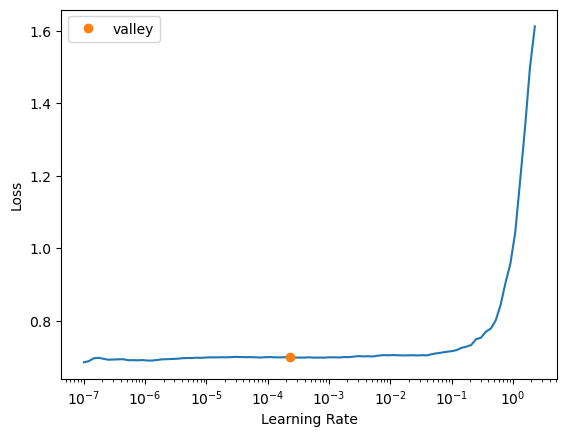

In [9]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = LSTM_FCNPlus(12, 2, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.696307,0.696134,0.483378,0.499494,00:05
1,0.693040,0.713065,0.479184,0.507583,00:05
2,0.690801,0.702989,0.488889,0.506572,00:05
3,0.686793,0.703286,0.507742,0.497472,00:06
4,0.682979,0.707213,0.474841,0.500506,00:06
5,0.679669,0.706300,0.521360,0.497472,00:06
6,0.677053,0.702859,0.499477,0.507583,00:06


KeyboardInterrupt: 

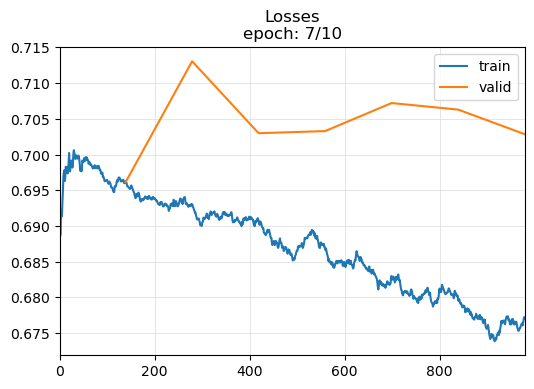

In [10]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(10, 2e-4)
print('\nElapsed time:', time.time() - start)

# MLSTM-FCN Baseline

SuggestedLRs(valley=0.0002754228771664202)

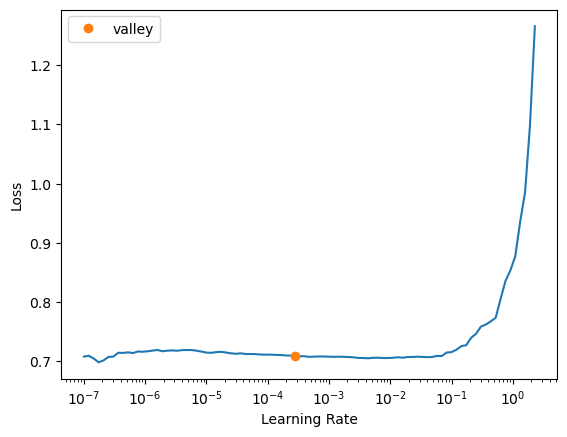

In [5]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = MLSTM_FCNPlus(9, 2, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.679882,0.689826,0.547462,0.578362,00:04
1,0.682471,0.688101,0.547358,0.578362,00:04
2,0.680315,0.691317,0.543543,0.573306,00:04
3,0.681693,0.696615,0.549163,0.566229,00:04
4,0.682978,0.696165,0.531827,0.562184,00:04
5,0.679851,0.693585,0.547683,0.577351,00:05
6,0.681728,0.687457,0.536005,0.570273,00:06
7,0.677633,0.703705,0.533564,0.522750,00:05
8,0.681655,0.692997,0.532454,0.535895,00:05
9,0.676858,0.690926,0.563317,0.538928,00:05


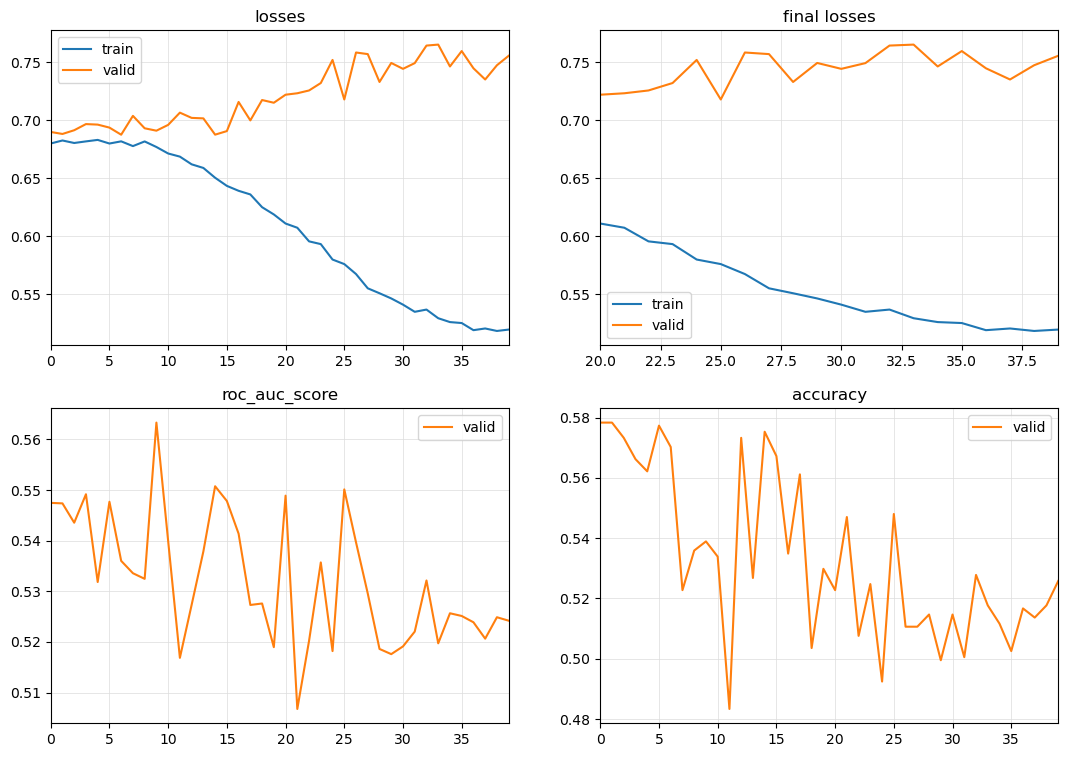


Elapsed time: 245.16797614097595


In [11]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(40, 3e-4)
print('\nElapsed time:', time.time() - start)

# GR-FCN Baseline

SuggestedLRs(valley=7.585775892948732e-05)

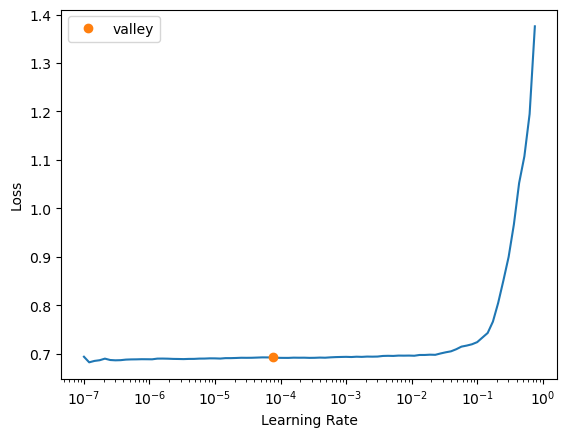

In [7]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = GRU_FCNPlus(9, 2, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.694049,0.690055,0.465568,0.557128,00:04
1,0.693863,0.689462,0.468216,0.566229,00:04
2,0.693016,0.692671,0.476511,0.569262,00:06
3,0.691293,0.693406,0.492245,0.574318,00:05
4,0.690322,0.691654,0.504992,0.568251,00:06
5,0.691203,0.692977,0.518806,0.560162,00:06
6,0.689838,0.689372,0.511195,0.564206,00:05
7,0.687755,0.690807,0.536711,0.565217,00:06
8,0.686590,0.688325,0.544813,0.575329,00:05
9,0.686654,0.691524,0.542039,0.565217,00:06


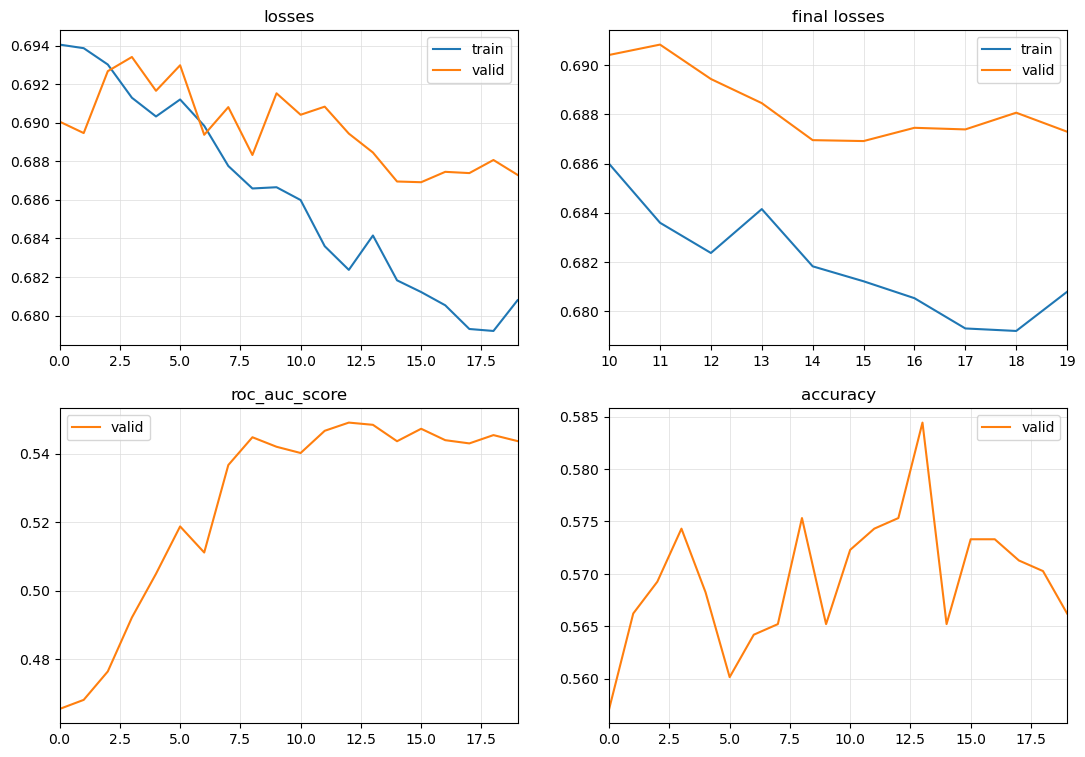


Elapsed time: 125.02936697006226


In [8]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(20, 7e-5)
print('\nElapsed time:', time.time() - start)

# Parameter tuning

In [10]:
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    hidden_size = trial.suggest_categorical('hidden_size', [25, 50, 100, 200])
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    rnn_layers = trial.suggest_categorical('rnn_layers', [1, 2, 4, 8])
    rnn_dropout = trial.suggest_float("rnn_dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    fc_dropout = trial.suggest_float("fc_dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    model =LSTM_FCNPlus(9, 2, dls.len,
                hidden_size=hidden_size,
                bidirectional=bidirectional,
                rnn_layers=rnn_layers,
                rnn_dropout= rnn_dropout,
                fc_dropout=fc_dropout)
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=FastAIPruningCallback(trial))

    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(15, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][3] # return the validation loss value of the last epoch 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=8)

[I 2023-03-03 16:28:19,301] A new study created in memory with name: no-name-b266b70a-4810-4254-b21e-cf825a3202d7
[I 2023-03-03 16:37:47,901] Trial 0 finished with value: 0.5247725248336792 and parameters: {'hidden_size': 200, 'bidirectional': False, 'rnn_layers': 8, 'rnn_dropout': 0.4, 'fc_dropout': 0.1, 'learning_rate': 0.00032654031163745705}. Best is trial 0 with value: 0.5247725248336792.
[I 2023-03-03 16:39:18,468] Trial 1 finished with value: 0.530839204788208 and parameters: {'hidden_size': 50, 'bidirectional': False, 'rnn_layers': 2, 'rnn_dropout': 0.4, 'fc_dropout': 0.4, 'learning_rate': 0.0007846276287836207}. Best is trial 1 with value: 0.530839204788208.
[I 2023-03-03 16:42:00,996] Trial 2 finished with value: 0.5864509344100952 and parameters: {'hidden_size': 25, 'bidirectional': False, 'rnn_layers': 8, 'rnn_dropout': 0.2, 'fc_dropout': 0.30000000000000004, 'learning_rate': 0.00013599319822964813}. Best is trial 2 with value: 0.5864509344100952.
[I 2023-03-03 16:43:15,866